**Library Imports:**

In [1]:
#Imports:
import requests
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import string
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

**Read in Data from notebook 01 & 02**

In [2]:
#Read in the data:
intj = pd.read_csv('data/intj.csv', index_col=0)
esfp = pd.read_csv('data/esfp.csv', index_col=0)

## Additional Cleaning & Data Merging

Since during our data loading process, any blank cells converted to null values, we should first check again to see how many null values were transferred over during our read ins:

In [3]:
#Let's check for null data:

In [4]:
intj.isnull().sum()

subreddit      0
selftext     566
title          0
dtype: int64

In [5]:
esfp.isnull().sum()

subreddit      0
selftext     425
title          0
dtype: int64

It looks like about roughly 25% of each data set now contains null values. Considering it is quite a substantial percentage, we know that we can't simply delete these rows and hope that our remaining data will be enough for analysis. As we mentioned in notebook 01, we can remember that some users elect to provide their posting information simply through the title with nothing else. That's why I elected to create an additional column that will combine the text found in the selftext column with the text in the title column. Since both pieces will come from the same post, this should maintain data integrity. The most effective method I found for this was to replace all the null values in selftext column with empty strings and then just combining them as shown below:

In [6]:
#replace null selftexts with empty string:
intj['selftext'].replace(np.nan, '', inplace=True)

In [7]:
#Combining selftext and title to a more useful 'combotext' column:
intj['combotext'] = intj['selftext'] + intj['title']

In [8]:
#sanity check
intj

,subreddit,selftext,title,combotext
0,intj,I'm genuinely stuck between being either an EN...,"If I was, say, an INTJ with depression, life-l...",I'm genuinely stuck between being either an EN...
1,intj,[View Poll](https://www.reddit.com/poll/l8056v),How many people text you per day?,[View Poll](https://www.reddit.com/poll/l8056v...
2,intj,Do you guys ever feel scared if the future you...,Are you guys scared?,Do you guys ever feel scared if the future you...
3,intj,"I'll try to keep this short, I'm a 20 year old...",I just need someone to hear me out,"I'll try to keep this short, I'm a 20 year old..."
4,intj,[View Poll](https://www.reddit.com/poll/l7yhe7),What do you think of r/wallstreetbets,[View Poll](https://www.reddit.com/poll/l7yhe7...
...,...,...,...,...
1811,intj,As we all know INTJs are considered unemotiona...,Being selectively emotional,As we all know INTJs are considered unemotiona...
1812,intj,,The 3 voices in my head all the day :-,The 3 voices in my head all the day :-
1813,intj,"I don’t want to say it, but I feel like I’m be...",INFJ Wife,"I don’t want to say it, but I feel like I’m be..."
1814,intj,I should preface this by saying that I am 18 a...,Dating as a female INTJ,I should preface this by saying that I am 18 a...


In [9]:
#combotext check for first row:
intj['combotext'][0]

"I'm genuinely stuck between being either an ENTP or an INTJ.If I was, say, an INTJ with depression, life-long ADHD, OCD, and ODD, how might I live my life or behave?"

Whatever do on one dataframe, we'll have to do on the other. That will allow us to effectively combine them further along in the project:

In [10]:
#same thing for espf
esfp['selftext'].replace(np.nan, '', inplace=True)

In [11]:
esfp['combotext'] = esfp['selftext'] + esfp['title']

In [12]:
esfp

,subreddit,selftext,title,combotext
0,ESFP,,[survey] MBTI—Enneagram Tritype Correlation,[survey] MBTI—Enneagram Tritype Correlation
1,ESFP,just for fun[View Poll](https://www.reddit.com...,Zodiac Sign,just for fun[View Poll](https://www.reddit.com...
2,ESFP,We currently have a very active MBTI discord s...,Any ESFPs (or others) here would like to join ...,We currently have a very active MBTI discord s...
3,ESFP,I have seen someone in r/ESTP saying that(i gu...,Are there anyone in romantic relatioship with ...,I have seen someone in r/ESTP saying that(i gu...
4,ESFP,"Like, a lot of people see (or refer to) the ES...","What is your idea of the ""party girl""?","Like, a lot of people see (or refer to) the ES..."
...,...,...,...,...
1893,ESFP,Are we ESFPs that much of a minority on Reddit...,Why is this subreddit so underpopulated?,Are we ESFPs that much of a minority on Reddit...
1894,ESFP,,A study found that the only leisure pastime fo...,A study found that the only leisure pastime fo...
1895,ESFP,,Asking the ESFP if the water is half-full or h...,Asking the ESFP if the water is half-full or h...
1896,ESFP,,Famous ESFPs - CelebrityTypes.com,Famous ESFPs - CelebrityTypes.com


In [13]:
#combotext check
esfp['combotext'][2]

'We currently have a very active MBTI discord server that consists of many personality types. We have a general chatroom where we talk, but we also do a lot of activities, such as group music listening sessions! DM or comment if you are interested in joining the server.Any ESFPs (or others) here would like to join our general MBTI discord server?'

Now that we have our combotext columns for both sets, let's combine the two into one single dataframe for our analysis. We can use the pd.concat method for this and attach the intj frame to our ESFP. Sine each dataframe has their own respective indicies, we will have to once again reset our index as we did before.

In [14]:
#combine intj and esfp:
df_cat = pd.concat([esfp, intj])

In [15]:
#reset index
df_cat.reset_index(drop = True, inplace=True)

In [16]:
#examining our next concatenated data:
df_cat

,subreddit,selftext,title,combotext
0,ESFP,,[survey] MBTI—Enneagram Tritype Correlation,[survey] MBTI—Enneagram Tritype Correlation
1,ESFP,just for fun[View Poll](https://www.reddit.com...,Zodiac Sign,just for fun[View Poll](https://www.reddit.com...
2,ESFP,We currently have a very active MBTI discord s...,Any ESFPs (or others) here would like to join ...,We currently have a very active MBTI discord s...
3,ESFP,I have seen someone in r/ESTP saying that(i gu...,Are there anyone in romantic relatioship with ...,I have seen someone in r/ESTP saying that(i gu...
4,ESFP,"Like, a lot of people see (or refer to) the ES...","What is your idea of the ""party girl""?","Like, a lot of people see (or refer to) the ES..."
...,...,...,...,...
3709,intj,As we all know INTJs are considered unemotiona...,Being selectively emotional,As we all know INTJs are considered unemotiona...
3710,intj,,The 3 voices in my head all the day :-,The 3 voices in my head all the day :-
3711,intj,"I don’t want to say it, but I feel like I’m be...",INFJ Wife,"I don’t want to say it, but I feel like I’m be..."
3712,intj,I should preface this by saying that I am 18 a...,Dating as a female INTJ,I should preface this by saying that I am 18 a...


### Pesky URLs

One thing we haven't addressed yet from a cleaning standpoint are all the links that users have included in their posts. Since our classifier will view this as nonsense and may introduce unnecessary noise during our modeling, we will want to remove these links. A handy way to do this is with the method shown below: 

In [17]:
# https://stackoverflow.com/questions/55422716/how-to-remove-http-url-links-from-a-data-frame-column-in-nlp
df_cat['combotext']=df_cat['combotext'].str.replace('http.*', '',regex = True)

In [18]:
df_cat['combotext']=df_cat['combotext'].str.replace('www.*', '',regex = True)

In [19]:
df_cat['combotext']

0             [survey] MBTI—Enneagram Tritype Correlation
1                                just for fun[View Poll](
2       We currently have a very active MBTI discord s...
3       I have seen someone in r/ESTP saying that(i gu...
4       Like, a lot of people see (or refer to) the ES...
                              ...                        
3709    As we all know INTJs are considered unemotiona...
3710               The 3 voices in my head all the day :-
3711    I don’t want to say it, but I feel like I’m be...
3712    I should preface this by saying that I am 18 a...
3713    Which music album would you enjoy listening to...
Name: combotext, Length: 3714, dtype: object

Another issue for our models, particularly our sentiment analysis analyzers is punctuation. Punctuation will make it difficult for our lemmatizer to recognize a word and know how to deal with it properly. In order to properly clean our combotext column we will have to both convert every character into lower case, but also remove all punctation found throughout the text. With help from google, I was able to implement the below function to simulatenously loop through the combotext row and convert each character to lower case and replace any punctuation with a space. 

### Punctuation

In [20]:
# https://www.codegrepper.com/code-examples/python/pandas+series+remove+punctuation
# Define the function to remove the punctuation and lower case column
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')
    return text.lower()
df_cat['combotext'] = df_cat['combotext'].apply(remove_punctuations)

In [21]:
#checking to see if lower and removed punct:
df_cat

,subreddit,selftext,title,combotext
0,ESFP,,[survey] MBTI—Enneagram Tritype Correlation,survey mbti—enneagram tritype correlation
1,ESFP,just for fun[View Poll](https://www.reddit.com...,Zodiac Sign,just for fun view poll
2,ESFP,We currently have a very active MBTI discord s...,Any ESFPs (or others) here would like to join ...,we currently have a very active mbti discord s...
3,ESFP,I have seen someone in r/ESTP saying that(i gu...,Are there anyone in romantic relatioship with ...,i have seen someone in r estp saying that i gu...
4,ESFP,"Like, a lot of people see (or refer to) the ES...","What is your idea of the ""party girl""?",like a lot of people see or refer to the es...
...,...,...,...,...
3709,intj,As we all know INTJs are considered unemotiona...,Being selectively emotional,as we all know intjs are considered unemotiona...
3710,intj,,The 3 voices in my head all the day :-,the 3 voices in my head all the day
3711,intj,"I don’t want to say it, but I feel like I’m be...",INFJ Wife,i don’t want to say it but i feel like i’m be...
3712,intj,I should preface this by saying that I am 18 a...,Dating as a female INTJ,i should preface this by saying that i am 18 a...


### Data Leakage

From: https://machinelearningmastery.com/data-leakage-machine-learning/

**What is Data Leakage:**

Data leakage can cause you to create overly optimistic if not completely invalid predictive models. Data leakage is when information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed.

So with this in mind we will have to remove 'buzz' words that might jeopardize the integrity of our model. First place to start intuitively is the name of the actual subreddits themselves. Next we can expand our thinking on that and remove the words that the acronym actually stand for. We also know that these two characteristics are terms under the umbrella of the Myers-Briggs Type Indicator, also known as mbti for short, so that has to go as well. This step will be a bit easier since we already know all posts are in lower case, so we will only have to scan for the 'lower cased version' of the data leaking culprits.

ESFP: **E**xtraverted **S**ensing **F**eeling **P**erceiving

intj: **I**ntroverted i**N**tuitive **T**hinking **J**udgement 

All these words and acronyms must go. We can do this by setting a pattern below and then as we've been doing throughout replacing them with a blank. 

In [22]:
#remove key words to avoid data leaking: 
#key words: mbti, esfp, intj
# https://stackoverflow.com/questions/49413005/replace-multiple-substrings-in-a-pandas-series-with-a-value
pattern = '|'.join(['mbti', 'esfp', 'intj','poll', 'introverted', 'judgement', 'intuitive', 'thinking',
                   'extraverted', 'sensing', 'feeling', 'perceiving'])
df_cat['combotext']=df_cat['combotext'].str.replace(pattern, '')

In [23]:
#sanity check
df_cat

,subreddit,selftext,title,combotext
0,ESFP,,[survey] MBTI—Enneagram Tritype Correlation,survey —enneagram tritype correlation
1,ESFP,just for fun[View Poll](https://www.reddit.com...,Zodiac Sign,just for fun view
2,ESFP,We currently have a very active MBTI discord s...,Any ESFPs (or others) here would like to join ...,we currently have a very active discord serve...
3,ESFP,I have seen someone in r/ESTP saying that(i gu...,Are there anyone in romantic relatioship with ...,i have seen someone in r estp saying that i gu...
4,ESFP,"Like, a lot of people see (or refer to) the ES...","What is your idea of the ""party girl""?",like a lot of people see or refer to the a...
...,...,...,...,...
3709,intj,As we all know INTJs are considered unemotiona...,Being selectively emotional,as we all know s are considered unemotional b...
3710,intj,,The 3 voices in my head all the day :-,the 3 voices in my head all the day
3711,intj,"I don’t want to say it, but I feel like I’m be...",INFJ Wife,i don’t want to say it but i feel like i’m be...
3712,intj,I should preface this by saying that I am 18 a...,Dating as a female INTJ,i should preface this by saying that i am 18 a...


### Stemming & Lemmatizing 

Next for proper sentiment analysis we will have to prepare the combotext either through stemming methods or lemmatizing. Stemming will attempt to recognize the root of the word and convert it into that format, while lemmatizing will analyze the word based on it's root inflection. This allows for better groupings of the word, i.e. cat and cats won't be counted separately, but together. Below is example of how to do both methods, after trying both stemming and lemmatizing, my analysis resulted more successfully with lemmatizing method, so that is what I elected to do. 

In [24]:
stemmer = PorterStemmer()
#for loop through combotext, return new column:
stems = []
for row in df_cat['combotext']:
    stems.append(' '.join([stemmer.stem(word) for word in row.split()]))

In [25]:
#lemmatizing:
#instantiate:
lemmatizer = WordNetLemmatizer()
#for loop through combotext, return new column:
lemmatized = []
for row in df_cat['combotext']:
    lemmatized.append(' '.join([lemmatizer.lemmatize(word) for word in row.split()]))


In [26]:
#Saving over the combo text with newly lemmatized column:
df_cat['combotext'] = lemmatized

In [27]:
#sanity check:
df_cat

,subreddit,selftext,title,combotext
0,ESFP,,[survey] MBTI—Enneagram Tritype Correlation,survey —enneagram tritype correlation
1,ESFP,just for fun[View Poll](https://www.reddit.com...,Zodiac Sign,just for fun view
2,ESFP,We currently have a very active MBTI discord s...,Any ESFPs (or others) here would like to join ...,we currently have a very active discord server...
3,ESFP,I have seen someone in r/ESTP saying that(i gu...,Are there anyone in romantic relatioship with ...,i have seen someone in r estp saying that i gu...
4,ESFP,"Like, a lot of people see (or refer to) the ES...","What is your idea of the ""party girl""?",like a lot of people see or refer to the a a p...
...,...,...,...,...
3709,intj,As we all know INTJs are considered unemotiona...,Being selectively emotional,a we all know s are considered unemotional but...
3710,intj,,The 3 voices in my head all the day :-,the 3 voice in my head all the day
3711,intj,"I don’t want to say it, but I feel like I’m be...",INFJ Wife,i don’t want to say it but i feel like i’m beg...
3712,intj,I should preface this by saying that I am 18 a...,Dating as a female INTJ,i should preface this by saying that i am 18 a...


### Post Length

Another often looked at feature during EDA is to analyze the post lenghts. Maybe one subreddit correlates with longer posts length? Maybe the other is notorious for shorter posts? Best way to examine this is to create another column (or two in our case) by using the lambda function to return the length of each post. To get the more useful number of words, we will have to first split the post into segmented list and then calculate the length that way as seen below:

In [28]:
#creating post length and worth count:
df_cat['post_length'] = df_cat['combotext'].apply(lambda x: len(x))
df_cat['post_word_count'] = df_cat['combotext'].apply(lambda x: len(x.split()))

In [29]:
#sanity check:
df_cat

,subreddit,selftext,title,combotext,post_length,post_word_count
0,ESFP,,[survey] MBTI—Enneagram Tritype Correlation,survey —enneagram tritype correlation,37,4
1,ESFP,just for fun[View Poll](https://www.reddit.com...,Zodiac Sign,just for fun view,17,4
2,ESFP,We currently have a very active MBTI discord s...,Any ESFPs (or others) here would like to join ...,we currently have a very active discord server...,321,60
3,ESFP,I have seen someone in r/ESTP saying that(i gu...,Are there anyone in romantic relatioship with ...,i have seen someone in r estp saying that i gu...,511,109
4,ESFP,"Like, a lot of people see (or refer to) the ES...","What is your idea of the ""party girl""?",like a lot of people see or refer to the a a p...,268,60
...,...,...,...,...,...,...
3709,intj,As we all know INTJs are considered unemotiona...,Being selectively emotional,a we all know s are considered unemotional but...,305,60
3710,intj,,The 3 voices in my head all the day :-,the 3 voice in my head all the day,34,9
3711,intj,"I don’t want to say it, but I feel like I’m be...",INFJ Wife,i don’t want to say it but i feel like i’m beg...,2727,540
3712,intj,I should preface this by saying that I am 18 a...,Dating as a female INTJ,i should preface this by saying that i am 18 a...,1472,279


## Word Count EDA

First let's take a look at the post length by word count distribution for each subreddit. Initially I elected to just perform this on the whole set but as we can see, we will run into outliers that we may want to address when creaing our visualizations.

#### Distplots

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


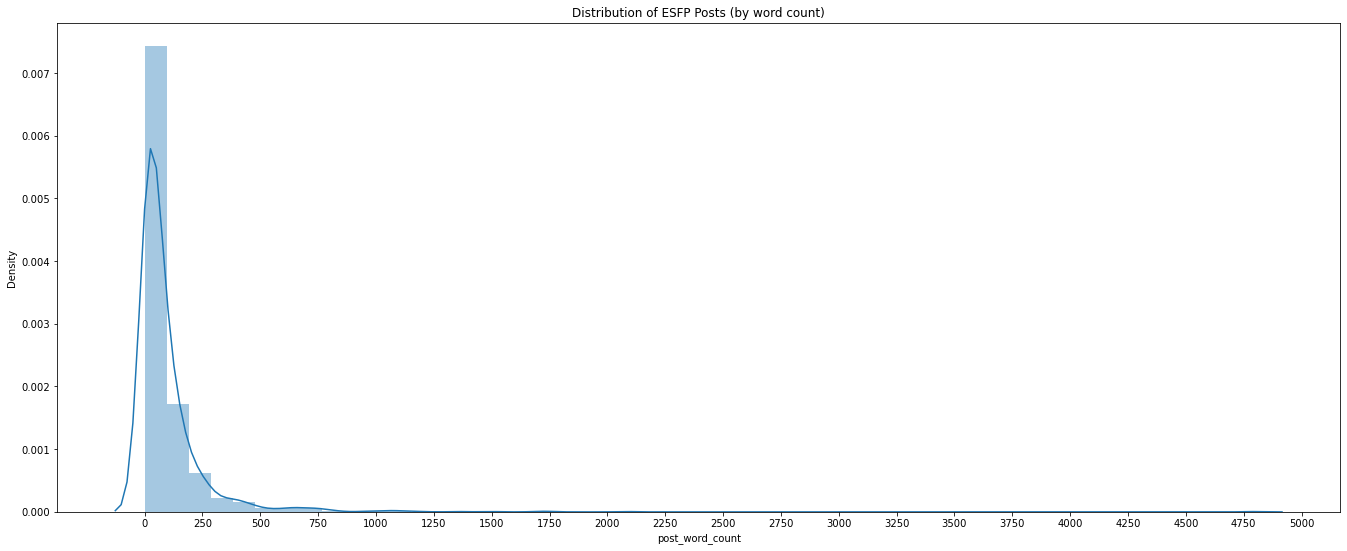

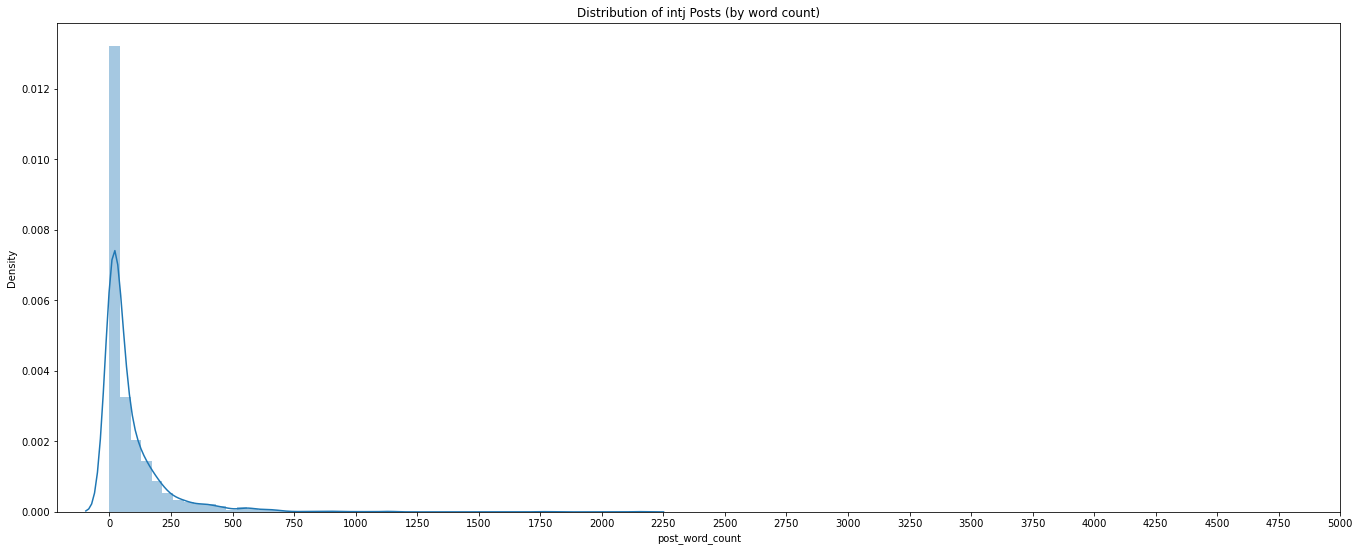

In [30]:
plt.figure(figsize=(23, 9))
sns.distplot(df_cat[df_cat['subreddit']=='ESFP']['post_word_count'], bins = 50)
plt.title('Distribution of ESFP Posts (by word count)')
plt.xticks(np.arange(0,5001,250))

plt.figure(figsize=(23, 9))
sns.distplot(df_cat[df_cat['subreddit']=='intj']['post_word_count'], bins = 50)
plt.title('Distribution of intj Posts (by word count)')
plt.xticks(np.arange(0,5001,250));

**Analysis:** We can observe from above that both subreddits are very right tailed in their distribution. The overwhelmng majority of posts falling below the 250 range with the bulk of the intj posts collecting in the 50 length ballpark. It is a little hard to see but we can safely assume that there are some outliers amongst the distrbution. An easy way to identify these is using boxplot and the .describe( ) method on our created length metric. 

#### Boxplots

Best way to visually represent outliers is boxplots, so let's create some for our respective subreddits below, again using post word count as our x variable:

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


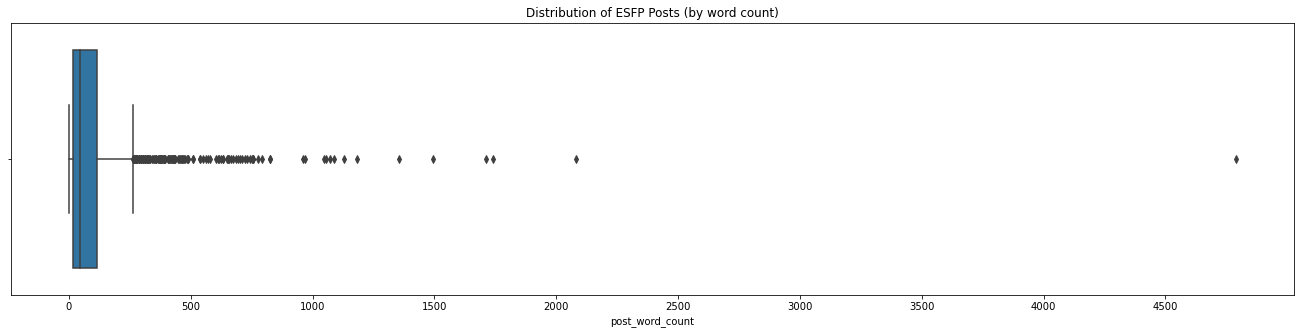

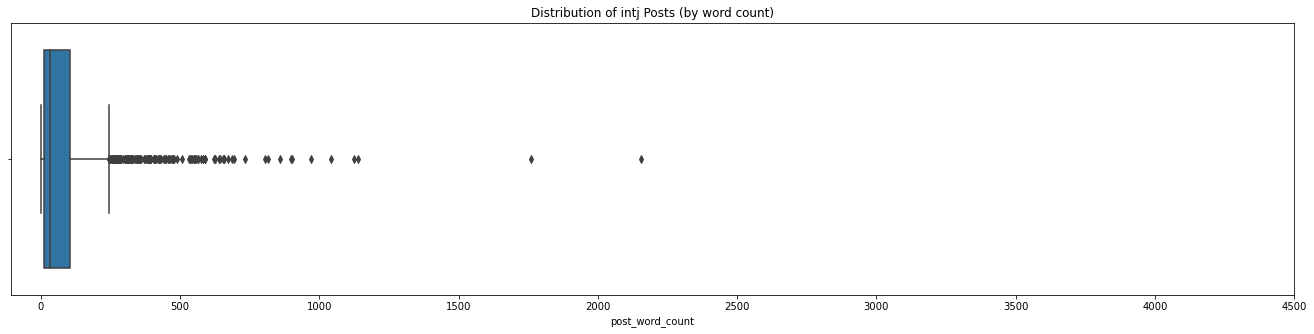

In [31]:
plt.figure(figsize=(23,5))
sns.boxplot(df_cat[df_cat['subreddit']=='ESFP']['post_word_count'])
plt.xticks(np.arange(0,5000,500))
plt.title('Distribution of ESFP Posts (by word count)')

plt.figure(figsize=(23,5))
sns.boxplot(df_cat[df_cat['subreddit']=='intj']['post_word_count'])
plt.xticks(np.arange(0,5000,500))
plt.title('Distribution of intj Posts (by word count)');

**Analysis:** We can see both subreddits contain a high number of outliers both holding a threshold ouf the high 200s range. Fortunately these outliers won't have an adverse impact on our modeling since post length won't be a determing feature of our model (in fact higher word count will actually only help it (more data)), but if we want to calculate our outlier benchmarks we can do so by utilizing the .describe on our metric and then calculating the IQR (Interquartile Range) and both adding and subtracting it to/from 3rd Q and 1st Q respectively. Let's perform for borth subreddits:

In [32]:
df_cat[df_cat['subreddit']=='ESFP']['post_word_count'].describe()

count    1898.000000
mean       97.564805
std       191.147555
min         0.000000
25%        15.000000
50%        44.000000
75%       114.000000
max      4789.000000
Name: post_word_count, dtype: float64

In [33]:
IQR = 1.5*(125-17)
print('ESFP outlier_bottom', 17 - IQR)
print('ESFP outlier_top',  125 + IQR)

ESFP outlier_bottom -145.0
ESFP outlier_top 287.0


In [34]:
df_cat[df_cat['subreddit']=='intj']['post_word_count'].describe()

count    1816.000000
mean       85.656388
std       143.344970
min         0.000000
25%        11.000000
50%        32.000000
75%       104.250000
max      2155.000000
Name: post_word_count, dtype: float64

In [35]:
IQR = 1.5*(104-11)
print('intj outlier_bottom', 11 - IQR)
print('intj outlier_top',  104 + IQR)

intj outlier_bottom -128.5
intj outlier_top 243.5


## Sentiment Analysis EDA

For Sentiment Analysis I elected to use VADER (Valence Aware Dictionary and sEntiment Reasoner). Per the documentation: "is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media." This makes it ideal for scanning reddit subs as it should be able to be able to address much of the language and text used throughout social media. VADER will scan a given chunk of text (post in this case) and will return 4 different metrics based on it's analysis. It gives a 'neg' (negative) score, for the weight of negative language used throughout, 'neu' (neutral), and 'pos' (positive) language used throughout. It will also compile this into a compound score which "is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate."

In [36]:
#Instantiate the model and apply it to each post using a for loop:
analyzer = SentimentIntensityAnalyzer()
pol_scores = []
for post in df_cat['combotext']:
    pol_scores.append(analyzer.polarity_scores(post))

Now we will want to attach these scores to each row and see if we can draw any interesting conclusions either by looking at our dataframe or more commonly through EDA

In [37]:
df_cat['vader_neg'] = 0
df_cat['vader_pos'] = 0
df_cat['vader_neu'] = 0
df_cat['vader_compound'] = 0

for i, q in enumerate(df_cat['combotext']):
    vs = analyzer.polarity_scores(q)
    df_cat.iloc[i, -4] = vs['neg']
    df_cat.iloc[i, -3] = vs['pos']
    df_cat.iloc[i, -2] = vs['neu']
    df_cat.iloc[i, -1] = vs['compound']

In [38]:
#Examining new dataframe:
df_cat

,subreddit,selftext,title,combotext,post_length,post_word_count,vader_neg,vader_pos,vader_neu,vader_compound
0,ESFP,,[survey] MBTI—Enneagram Tritype Correlation,survey —enneagram tritype correlation,37,4,0.000,0.000,1.000,0.0000
1,ESFP,just for fun[View Poll](https://www.reddit.com...,Zodiac Sign,just for fun view,17,4,0.000,0.524,0.476,0.5106
2,ESFP,We currently have a very active MBTI discord s...,Any ESFPs (or others) here would like to join ...,we currently have a very active discord server...,321,60,0.078,0.163,0.759,0.7233
3,ESFP,I have seen someone in r/ESTP saying that(i gu...,Are there anyone in romantic relatioship with ...,i have seen someone in r estp saying that i gu...,511,109,0.083,0.178,0.739,0.9128
4,ESFP,"Like, a lot of people see (or refer to) the ES...","What is your idea of the ""party girl""?",like a lot of people see or refer to the a a p...,268,60,0.039,0.189,0.773,0.8591
...,...,...,...,...,...,...,...,...,...,...
3709,intj,As we all know INTJs are considered unemotiona...,Being selectively emotional,a we all know s are considered unemotional but...,305,60,0.000,0.277,0.723,0.9668
3710,intj,,The 3 voices in my head all the day :-,the 3 voice in my head all the day,34,9,0.000,0.000,1.000,0.0000
3711,intj,"I don’t want to say it, but I feel like I’m be...",INFJ Wife,i don’t want to say it but i feel like i’m beg...,2727,540,0.111,0.114,0.776,-0.4584
3712,intj,I should preface this by saying that I am 18 a...,Dating as a female INTJ,i should preface this by saying that i am 18 a...,1472,279,0.072,0.035,0.893,-0.8287


**CSV SAVE**

In [39]:
# df_cat.to_csv('combo_with_sent.csv')

For EDA purposes it might be easier to create two subset dataframes for now to examine the distributions 

In [40]:
esfp_only = df_cat[df_cat['subreddit']=='ESFP']
intj_only = df_cat[df_cat['subreddit']=='intj']

In [41]:
ESFP_non_neut = esfp_only[esfp_only['vader_neu'] != 1.000]
intj_non_neut = intj_only[intj_only['vader_neu'] != 1.000]

I have also filtered out for all the completely neutral posts that might visually skew the distributions, since they may be a result from a removed url post or something without much value. Let's take a look at the distribution of the the three sentiment scores for the both subreddits:

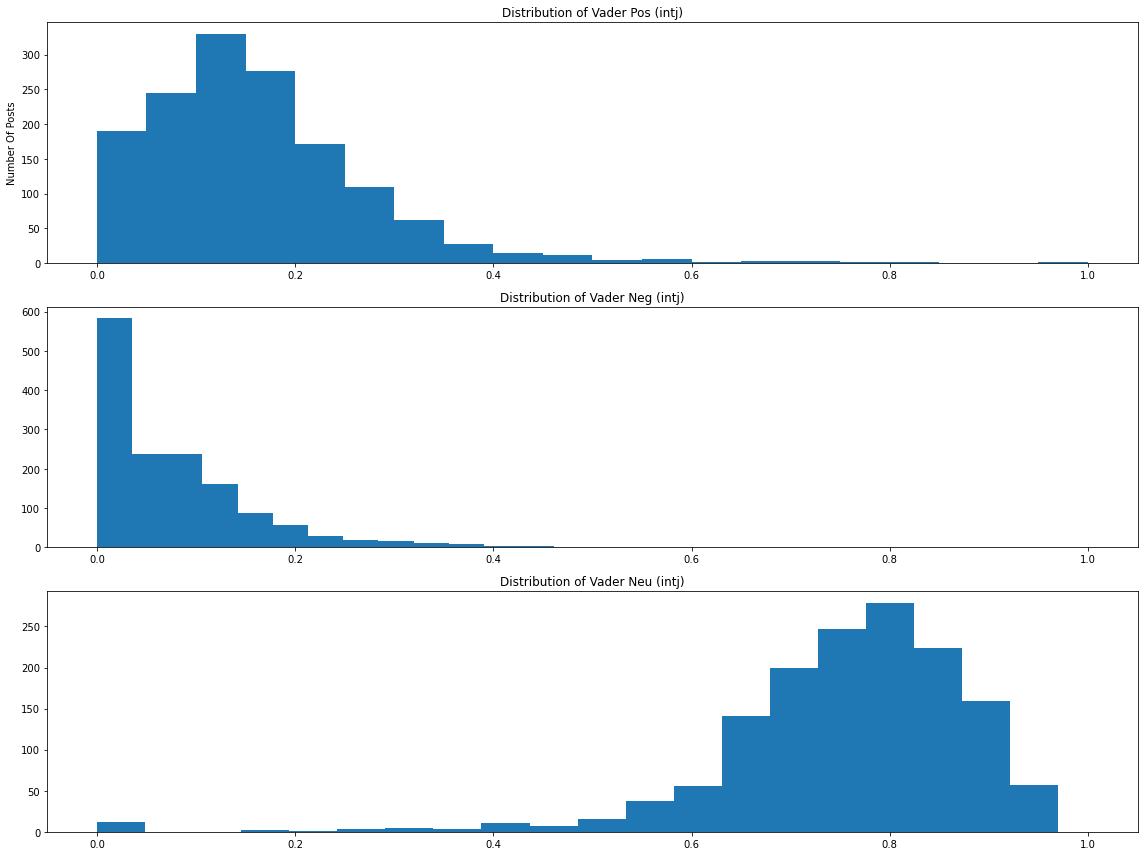

In [42]:
# Establish figure size.
plt.figure(figsize = (16,12))

# We can create subplots, which allows us to have multiple subplots in the same plot.
# plt.subplot(3, 1, 1) means we have 3 rows, 1 column, and are referencing plot 1.
ax1 = plt.subplot(3, 1, 1)
ax1.hist(intj_non_neut['vader_pos'], bins=20)
ax1.set_title('Distribution of Vader Pos (intj)')
ax1.set_ylabel('Number Of Posts')

# plt.subplot(3, 1, 2) means we have 3 rows, 1 column, and are referencing plot 2.
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.hist(intj_non_neut['vader_neg'], bins=20)
ax2.set_title("Distribution of Vader Neg (intj)")

# plt.subplot(3, 1, 3) means we have 3 rows, 1 column, and are referencing plot 3.
ax3 = plt.subplot(3, 1, 3, sharex=ax2)
ax3.hist(intj_non_neut['vader_neu'], bins=20)
ax3.set_title('Distribution of Vader Neu (intj)')

plt.tight_layout(); # adds more space

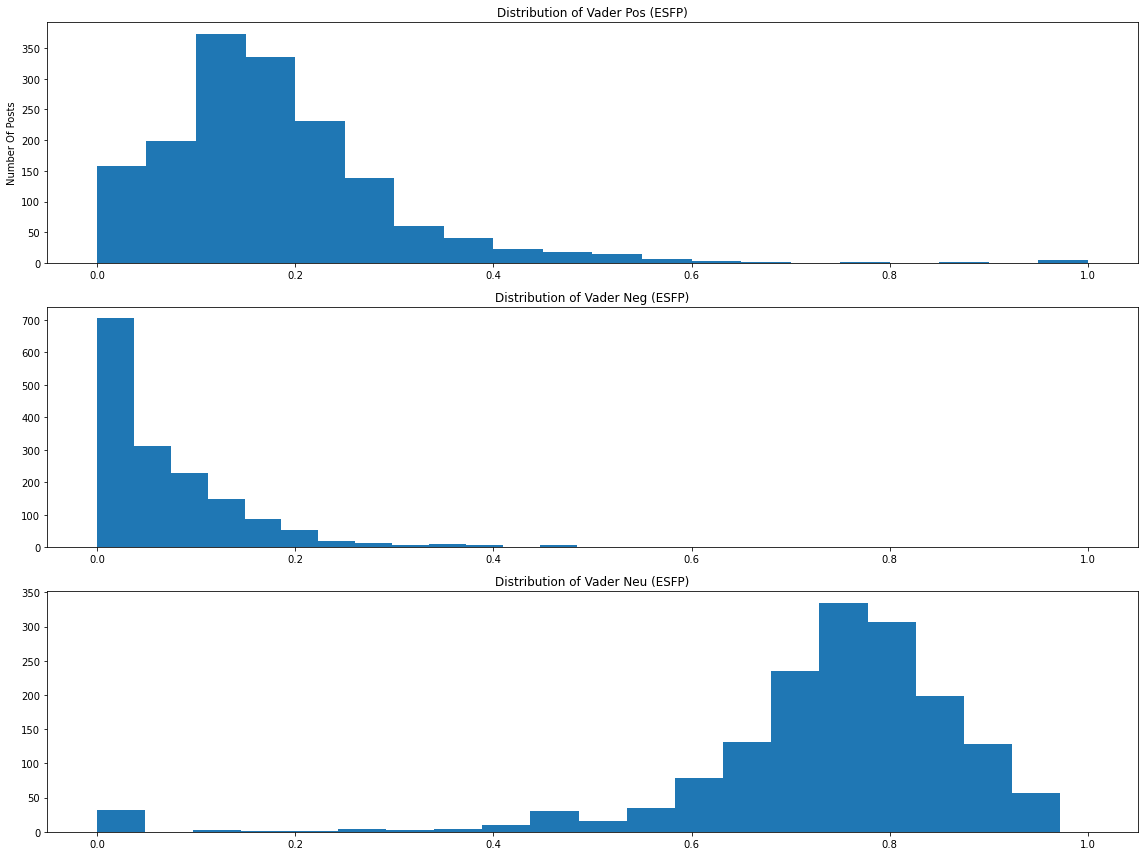

In [43]:
# Establish figure size.
plt.figure(figsize = (16,12))

# We can create subplots, which allows us to have multiple subplots in the same plot.
# plt.subplot(3, 1, 1) means we have 3 rows, 1 column, and are referencing plot 1.
ax1 = plt.subplot(3, 1, 1)
ax1.hist(ESFP_non_neut['vader_pos'], bins=20)
ax1.set_title('Distribution of Vader Pos (ESFP)')
ax1.set_ylabel('Number Of Posts')

# plt.subplot(3, 1, 2) means we have 3 rows, 1 column, and are referencing plot 2.
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.hist(ESFP_non_neut['vader_neg'], bins=20)
ax2.set_title("Distribution of Vader Neg (ESFP)")

# plt.subplot(3, 1, 3) means we have 3 rows, 1 column, and are referencing plot 3.
ax3 = plt.subplot(3, 1, 3, sharex=ax2)
ax3.hist(ESFP_non_neut['vader_neu'], bins=20)
ax3.set_title('Distribution of Vader Neu (ESFP)')

plt.tight_layout(); # adds more space

**Analysis:** Examing these two groups of distribution charts by subreddit, The seem to beem fairly similarly shaped, which is to be somewhat expected with posts of these nature. Particularly with something like sentiment analysis, it is difficult to account for context of the post. But if we were to draw a conclusion we might be able to say tha ESPF posts contain slightly greater distribution of posts containing language with higher a pos VADER score (but not by a discernable amount)

Lastly let's look at the distribution of compound VADER scores and see if there's anything we can gain from that comparison. 

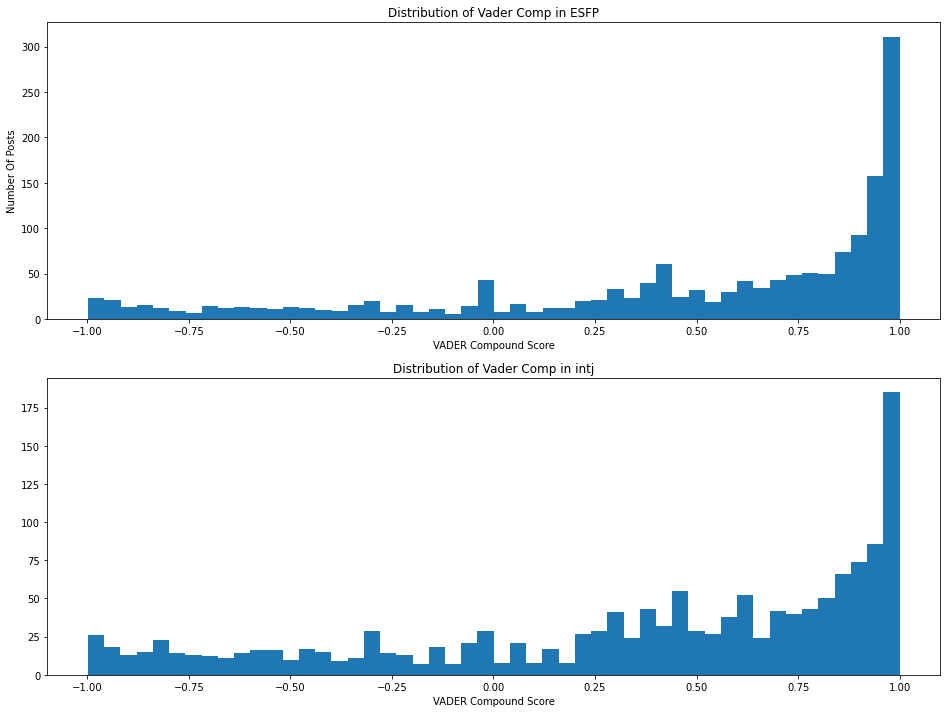

In [44]:
# Establish figure size.
plt.figure(figsize = (16,12))

# We can create subplots, which allows us to have multiple subplots in the same plot.
# plt.subplot(3, 1, 1) means we have 3 rows, 1 column, and are referencing plot 1.
ax1 = plt.subplot(2, 1, 1)
ax1.hist(ESFP_non_neut['vader_compound'], bins=50)
ax1.set_title('Distribution of Vader Comp in ESFP')
ax1.set_ylabel('Number Of Posts')
ax1.set_xlabel('VADER Compound Score')

# plt.subplot(3, 1, 2) means we have 3 rows, 1 column, and are referencing plot 2.
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.hist(intj_non_neut['vader_compound'], bins=50)
ax2.set_title("Distribution of Vader Comp in intj")
ax2.set_xlabel('VADER Compound Score');

**Analysis:** Compound scores seem fairly similar with a left trail for both subreddits, but it is interesting to note the higher area of distribution of negative compound scores with intj posts compared to ESFP. Again, as previously mentioned, it's important to note context issues, but it would be enough to lead us to investigate if there is anything worthwile in the data from a sentiment analysis standpoint. It would make sense that a subreddit containing a more stern, planned group contains more "serious" language and the more social subreddit contains "lighter" language overall.

Before our last visualization, we should make sure we convert our subreddit column into a numerical format. Since our interested variable is determining ESFP, we will set that to 1, and intj as 0. We can do this easily enough again with a lamda function shown below:

In [45]:
#Binarize: setting ESPF = 1 and intj = 0:
df_cat['subreddit'] = df_cat['subreddit'].apply(lambda x: 1 if x == 'ESFP' else 0)

### Correlation Heatmap

Let's see if we can identify any outstanding correlations between one score and our target variable. As we've explored in previous projects, a great way to do that is with heatmap correlations. I've isolated a single column for just my targeted subreddit and compared them against the Vader scores and post length metrics.

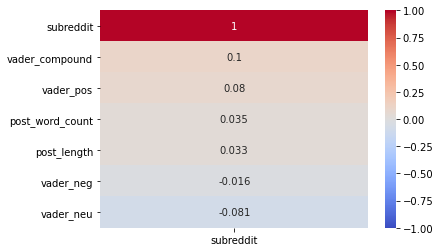

In [46]:
sns.heatmap(df_cat.corr()[['subreddit']].sort_values('subreddit', ascending=False),
           vmax=1,
           vmin=-1,
           cmap='coolwarm',
           annot=True);

**Analysis:** It doesn't look like there as any standout correlations as everything lands pretty close to the neutral 0 value which would signify noncorrelation. while vader compound is the highest it is still a low enough score that we can conclude these should not be our determining model features. 

**CSV SAVE**

In [47]:
# df_cat.to_csv('combo_binarized.csv')

## Word Vectorization EDA

Word Vectorization utilizes two helpful methods: CountVectorization and TFIDFVectorization. CountVectors instantiates and fits (similar to a model) and will allow us to scan the fitted column to calculate the prevalance of a word throughout the post. Performing this for all of the column will allow us to then create a dataframe where we can return the most frequently occuring words across both subreddits. TFIDFVectorization performs a similar task but returns which words are most "impactful" in this text. This will allow us to penalize more common words and will give greater weight to rarere words. 

#### CountVectorization

Let's first look at the most common words appearing for each subreddit and graph them:

In [48]:
#Instantiate (be sure to use the built in stop words feature so you don't collect meaningless words):
cvec = CountVectorizer(stop_words='english')
#Fit:
cvec.fit(df_cat['combotext'])
#Create a dataframe with transformed function 
vector = pd.DataFrame(cvec.transform(df_cat['combotext']).todense(),
                  columns = cvec.get_feature_names())

In [49]:
#Creating a new dataframe with the top 50 words found in the ESFP subreddit:
top_50_esfp=vector[vector['subreddit']==1].sum().sort_values(ascending=False).head(51)
esfp_50=pd.DataFrame(top_50_esfp[1:])
esfp_50.reset_index(level=0, inplace=True)
esfp_50.rename(columns={'index':'word', 0:'word_count'}, inplace=True)

#Creating a new dataframe with the top 50 words found in the ESFP subreddit:
top_50_intj=vector[vector['subreddit']==0].sum().sort_values(ascending=False).head(50)
intj_50=pd.DataFrame(top_50_intj)
intj_50.reset_index(level=0, inplace=True)
intj_50.rename(columns={'index':'word', 0:'word_count'}, inplace=True)

Now we can chart out the Top 25 and Top 26-50 words for both subreddits:

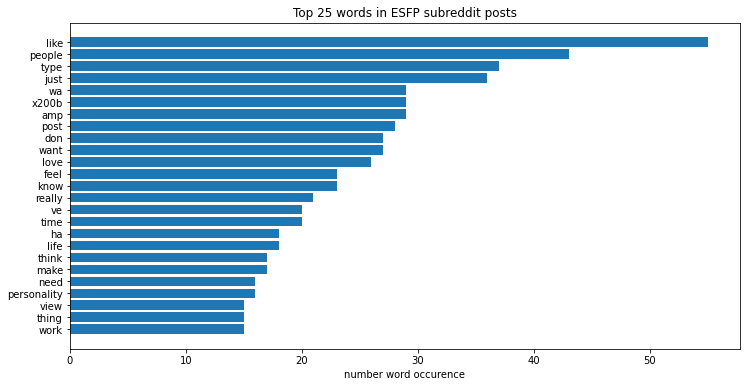

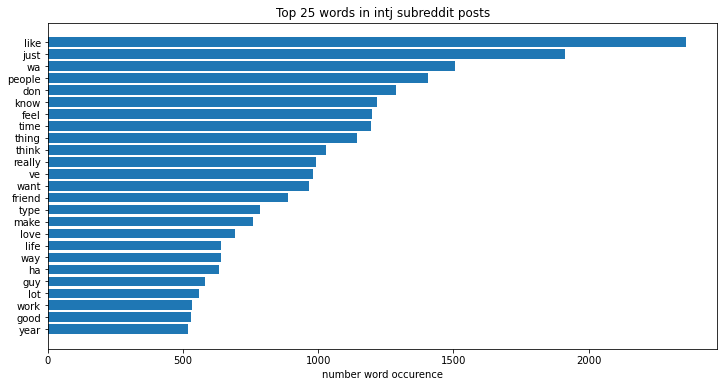

In [50]:
e_sort=esfp_50.sort_values('word_count')
plt.figure(figsize=(12, 6))
plt.barh(e_sort['word'][25:50], e_sort['word_count'][25:50])
plt.title('Top 25 words in ESFP subreddit posts')
plt.xlabel('number word occurence')

i_sort=intj_50.sort_values('word_count')
plt.figure(figsize=(12, 6))
plt.barh(i_sort['word'][25:50], i_sort['word_count'][25:50])
plt.title('Top 25 words in intj subreddit posts')
plt.xlabel('number word occurence');

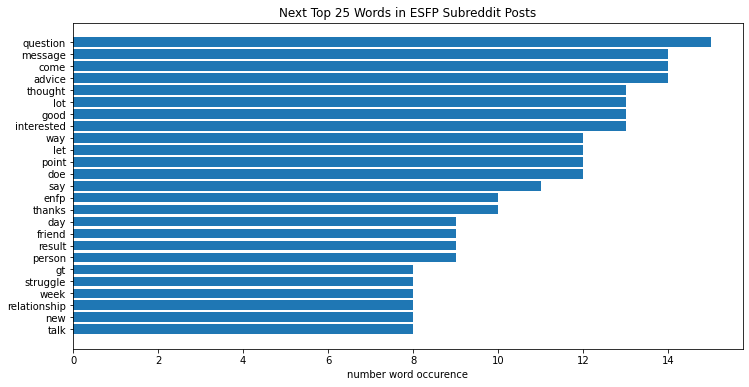

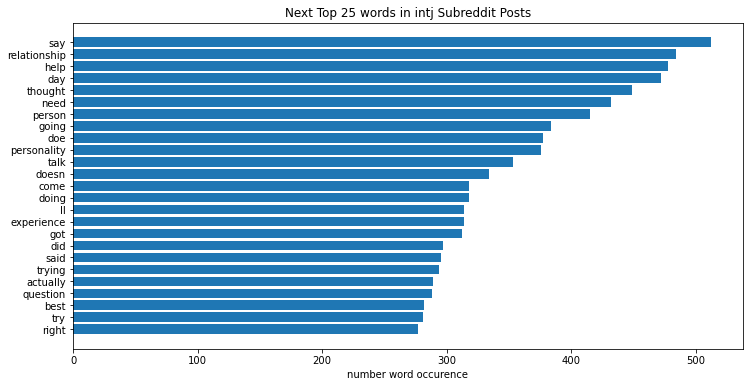

In [51]:
e_sort=esfp_50.sort_values('word_count')
plt.figure(figsize=(12, 6))
plt.barh(e_sort['word'][0:25], e_sort['word_count'][0:25])
plt.title('Next Top 25 Words in ESFP Subreddit Posts')
plt.xlabel('number word occurence')

i_sort=intj_50.sort_values('word_count')
plt.figure(figsize=(12, 6))
plt.barh(i_sort['word'][0:25], i_sort['word_count'][0:25])
plt.title('Next Top 25 words in intj Subreddit Posts')
plt.xlabel('number word occurence');

**Analysis**: It looks like our subreddits use awfully similar languages unfortunately. This will pose a problem when trying to design an effective model, so we should try and find a way to observe more unique elements found throughout the posts. A good place to start is to, as we mentioned, try out TFIDFVectorization. But also another handy technique will be to build out our own set of stop words and try to find words that are more unique to one post versus the other. If we can find that then we can then use those as our features during modeling. 

### TFIDF

Let's first start with a couple of the buzzwords that we think might not help us with feature selection. It will also be necessary to convert our texts into one long string. This will allow us to sort the top TVEC scores easier once we've created the corresponding dataframe:

In [52]:
#stopwords extend from: https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist
stopwords = nltk.corpus.stopwords.words('english')
new_stops = ['poll', 'like', 'just', 'wa', 've', 'http', 'subreddit']
stopwords.extend(new_stops)

In [53]:
esfp_content = esfp_only['combotext']
intj_content = intj_only['combotext']

In [54]:
#creating two separate lists of one long string
esfp_string_list=["".join(x) for x in esfp_only['combotext']]
intj_string_list=["".join(x) for x in intj_only['combotext']]

In [55]:
#converting the list to string function:
# https://www.geeksforgeeks.org/python-program-to-convert-a-list-to-string/
def listToString(s):  
    str1 = " "   
    return (str1.join(s))

In [56]:
#creating the two strings:
x=listToString(esfp_string_list)
y=listToString(intj_string_list)

In [57]:
#instantiting with our first batch of custom stopwords and then fitting on both of our srings:
tvec = TfidfVectorizer(stop_words=stopwords)
tvec.fit([x, y])

TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [58]:
#creating the dataframe
df = pd.DataFrame(tvec.transform([x, y]).todense(),
                  columns = tvec.get_feature_names(),
                 index = ['esfp', 'intj'])

Here we can sort our dataframe first by top row and next by bottom. This will give us an idea of reoccuring words and their weight throughout. The ones that are common we will want to add to our new set of stop words:

In [59]:
df.T.sort_values('esfp', ascending = False).head(20).T

,people,get,know,time,thing,feel,want,really,type,friend,think,would,one,love,guy,also,make,life,ha,always
esfp,0.220950,0.207308,0.201080,0.196928,0.191589,0.188327,0.187141,0.174091,0.169346,0.164304,0.164304,0.161635,0.143544,0.137612,0.118038,0.117148,0.115369,0.109141,0.104692,0.100243
intj,0.257845,0.174657,0.202747,0.200946,0.184741,0.212830,0.131443,0.153770,0.091110,0.124601,0.178979,0.188342,0.154491,0.092910,0.068062,0.113797,0.140446,0.105155,0.108756,0.095791


In [60]:
df.T.sort_values('intj', ascending = False).head(20).T

,people,feel,know,time,would,thing,think,get,one,really,make,want,even,friend,way,also,ha,life,something,selfie
esfp,0.220950,0.188327,0.201080,0.196928,0.161635,0.191589,0.164304,0.207308,0.143544,0.174091,0.115369,0.187141,0.098167,0.164304,0.098760,0.117148,0.104692,0.109141,0.093422,0.000000
intj,0.257845,0.212830,0.202747,0.200946,0.188342,0.184741,0.178979,0.174657,0.154491,0.153770,0.140446,0.131443,0.126762,0.124601,0.115598,0.113797,0.108756,0.105155,0.103714,0.100214


In [61]:
#add common stop words to make more unique:
'people', 'know', 'time', 'get', 'feel', 'thing', 'want', 'friend', 'would', 'even', 'also', 'ha', 'life', 'something', 'always'

('people',
 'know',
 'time',
 'get',
 'feel',
 'thing',
 'want',
 'friend',
 'would',
 'even',
 'also',
 'ha',
 'life',
 'something',
 'always')

After performing this a few times I was able to arrive at the bottom 

In [62]:
stopwords = nltk.corpus.stopwords.words('english')
new_stops = ['poll', 'like', 'just', 'wa', 've', 'http', 'subreddit', 'people', 'know', 'time', 'get',
             'feel', 'thing', 'want', 'friend','would', 'even', 'also', 'ha', 'life', 'something', 
             'always', 'think', 'say', 'one', 'see', 'go', 'say', 'day', 'work', 'lot', 'really', 'much',
            'need', 'personality', 'person', 'enfp', 'make', 'way', 'someone', 'year', 'good',
            'anyone', 'well', 'thought', 'never', 'thought', 'going']
stopwords.extend(new_stops)

In [63]:
tvec = TfidfVectorizer(stop_words=stopwords)
tvec.fit([x, y])

TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [64]:
df_new = pd.DataFrame(tvec.transform([x, y]).todense(),
                  columns = tvec.get_feature_names(),
                 index = ['esfp', 'intj'])

In [65]:
df_new.T.sort_values('esfp', ascending = False).head(20).T

,type,love,guy,relationship,help,find,talk,could,se,around,come,take,question,doe,back,sometimes,best,everyone,pretty,got
esfp,0.273322,0.222104,0.190511,0.154132,0.141687,0.105787,0.105787,0.09717,0.092384,0.090469,0.090469,0.089512,0.087118,0.086640,0.085204,0.084725,0.084725,0.083768,0.082332,0.081853
intj,0.150032,0.152997,0.112079,0.101405,0.112672,0.156555,0.083614,0.12216,0.026092,0.066417,0.085393,0.100219,0.074126,0.123939,0.077684,0.072940,0.064638,0.090138,0.060487,0.086579


In [66]:
df_new.T.sort_values('intj', ascending = False).head(20).T

,selfie,find,love,type,doe,could,else,help,guy,since,relationship,take,still,view,experience,first,actually,many,everyone,better
esfp,0.000000,0.105787,0.222104,0.273322,0.086640,0.09717,0.075630,0.141687,0.190511,0.080417,0.154132,0.089512,0.078502,0.040208,0.078502,0.062227,0.067014,0.069886,0.083768,0.056962
intj,0.165024,0.156555,0.152997,0.150032,0.123939,0.12216,0.118602,0.112672,0.112079,0.107928,0.101405,0.100219,0.094882,0.094882,0.094882,0.093103,0.091917,0.091324,0.090138,0.089545


While we had to remove quite a bit of words, hopefully now we have discovered enough identifying words that will be able to provide a working classifier model. We will want to apply these two lists as our features initially on our fully tfidfVectorized list and create our models accordingly. For modeling and analysis refering to notebook 04

**CSV SAVE**

In [67]:
# df_new.to_csv('tvec_final.csv')

Saving our full TVEC dataframe for modeling purposes:

In [68]:
stopwords = nltk.corpus.stopwords.words('english')
new_stops = ['poll', 'like', 'just', 'wa', 've', 'http', 'subreddit', 'people', 'know', 'time', 'get',
             'feel', 'thing', 'want', 'friend','would', 'even', 'also', 'ha', 'life', 'something', 
             'always', 'think', 'say', 'one', 'see', 'go', 'say', 'day', 'work', 'lot', 'really', 'much',
            'need', 'personality', 'person', 'enfp', 'make', 'way', 'someone', 'year', 'good',
            'anyone', 'well', 'thought', 'never', 'thought', 'going']
stopwords.extend(new_stops)

In [69]:
content=df_cat['combotext']

In [70]:
tvec = TfidfVectorizer(stop_words=stopwords)
tvec.fit(content)

TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [71]:
total_tvec = pd.DataFrame(tvec.transform(content).todense(),
                  columns = tvec.get_feature_names())

In [72]:
total_tvec['subreddit']=df_cat['subreddit']

In [73]:
# total_tvec.to_csv('total_tvec_df.csv')